In [196]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# import glob
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000
filename = "NDWI_Mask_130_resized.tif"
image_path = "./GEE_Masks/GEE_resized/"

import json

with open('config.json') as json_file:
    config = json.load(json_file)
    corruption = config['corruption_level']
    image_dim = config['image_dim']

# Erosion


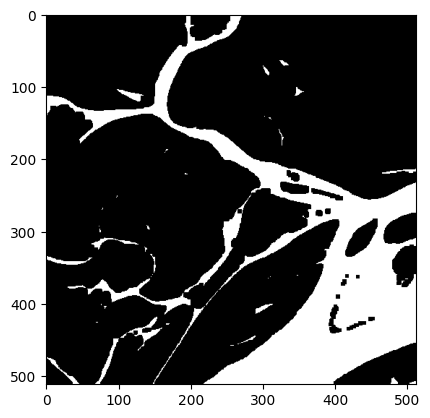

In [197]:
img = cv.imread(image_path+filename, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(img,kernel,iterations = 1)
plt.imshow(erosion,cmap='gray')
plt.show()

In [198]:
img = Image.open(image_path+filename)

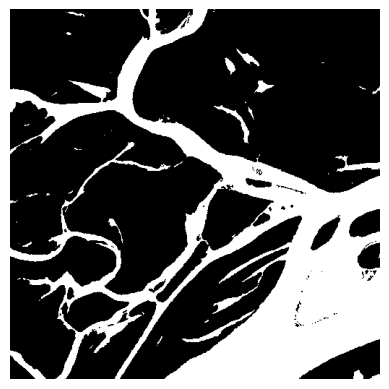

In [199]:
# Convert the image to numpy array
img_array = np.array(img)

# Plot the image
plt.imshow(img_array, cmap='gray')  # You can change the colormap as per your need
plt.axis('off')  # Turn off axis
plt.show()

# Dilation

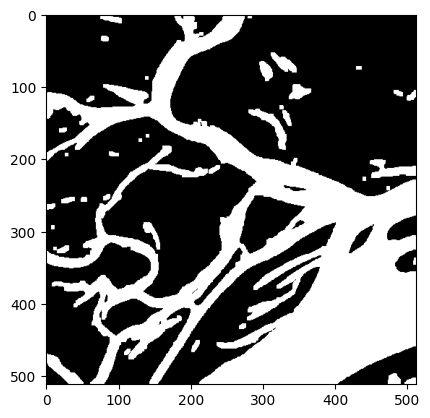

In [200]:
img = cv.imread(image_path+filename, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
kernel = np.ones((5,5),np.uint8)
dilation = cv.dilate(img,kernel,iterations = 1)
plt.imshow(dilation,cmap='gray')
plt.show()

In [201]:
import os
import cv2 as cv
import numpy as np
import random
import shutil
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import rasterio
from glob import glob
import pandas as pd

In [202]:
def count_changed_pixels(original, eroded):
    return np.sum(original != eroded)

def apply_erosion_with_threshold(img, target_changes, kernel):
    eroded_img = img.copy()
    total_changed = 0
    iterations = 0
    total_changed_prev = 0
    
    while total_changed < target_changes:
        eroded_img_new = cv.erode(eroded_img, kernel, iterations=1)
        total_changed = count_changed_pixels(img, eroded_img_new)
        if (total_changed > target_changes):
            return eroded_img, total_changed_prev
        else:
            eroded_img = eroded_img_new
            total_changed_prev = total_changed
        
        iterations += 1
        if iterations > 100:  # Prevent infinite loop
            break
    
    return eroded_img, total_changed

# Function to apply dilation with stopping criteria based on the number of pixel changes
def apply_dilation_with_threshold(img, target_changes, kernel):
    dilated_img = img.copy()
    total_changed = 0
    iterations = 0
    total_changed_prev = 0

    while total_changed < target_changes:
        dilated_img_new = cv.dilate(dilated_img, kernel, iterations=1)
        total_changed = count_changed_pixels(img, dilated_img_new)
        if (total_changed > target_changes):
            return dilated_img_new, total_changed_prev
        else:
            dilated_img = dilated_img_new
            total_changed_prev = total_changed

        iterations += 1
        if iterations > 100:  # Prevent infinite loop
            break

    return dilated_img, total_changed

In [203]:
def min_corrupted_pixels(set_1, set_2, kernel, combined_erosion, combined_dilation):
    # Initialize variables to accumulate the sum of corrupted pixels
    min_changed_pixels_erosion = sys.maxsize
    min_changed_pixels_dilation = sys.maxsize
    
    # Lists to store corrupted pixels for plotting
    erosion_pixel_counts = []
    dilation_pixel_counts = []

    # Loop through all images in set_1
    for img_name in set_1:
        img_path = os.path.join(combined_erosion, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        assert img is not None, f"File {img_name} could not be read"

        # Apply erosion and count changed pixels
        eroded_img = cv.erode(img, kernel, iterations=1)
        num_changed_pixels = count_changed_pixels(img, eroded_img)
        erosion_pixel_counts.append(num_changed_pixels)
        min_changed_pixels_erosion = min(num_changed_pixels, min_changed_pixels_erosion)

    # Loop through all images in set_2
    for img_name in set_2:
        img_path = os.path.join(combined_dilation, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        assert img is not None, f"File {img_name} could not be read"

        # Apply dilation and count changed pixels
        dilated_img = cv.dilate(img, kernel, iterations=1)
        num_changed_pixels = count_changed_pixels(img, dilated_img)
        dilation_pixel_counts.append(num_changed_pixels)
        min_changed_pixels_dilation = min(num_changed_pixels, min_changed_pixels_dilation)

    # Plot the number of corrupted pixels for each image
    plt.figure(figsize=(10, 5))
    plt.plot(erosion_pixel_counts, label='Erosion')
    plt.plot(dilation_pixel_counts, label='Dilation')
    plt.xlabel('Image Index')
    plt.ylabel('Number of Corrupted Pixels')
    plt.title('Number of Corrupted Pixels per Image')
    plt.legend()
    plt.show()

    return min_changed_pixels_erosion, min_changed_pixels_dilation

In [204]:
def max_corrupted_pixels(set_1, set_2, kernel, combined_erosion, combined_dilation):
    # Initialize variables to accumulate the sum of corrupted pixels
    max_changed_pixels_erosion = 0
    max_changed_pixels_dilation = 0

    # Loop through all images in set_1
    for img_name in set_1:
        img_path = os.path.join(combined_erosion, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        assert img is not None, f"File {img_name} could not be read"

        # Apply erosion and count changed pixels
        eroded_img = cv.erode(img, kernel, iterations=1)
        num_changed_pixels = count_changed_pixels(img, eroded_img)
        # print(num_changed_pixels)
        max_changed_pixels_erosion = max(num_changed_pixels,max_changed_pixels_erosion)

    # Loop through all images in set_2
    for img_name in set_2:
        img_path = os.path.join(combined_dilation, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        assert img is not None, f"File {img_name} could not be read"

        # Apply dilation and count changed pixels
        dilated_img = cv.dilate(img, kernel, iterations=1)
        num_changed_pixels = count_changed_pixels(img, dilated_img)
        # print(num_changed_pixels)
        max_changed_pixels_dilation = max(num_changed_pixels,max_changed_pixels_dilation)

    # Calculate the average number of corrupted pixels
    # avg_changed_pixels_erosion = max_changed_pixels_erosion / len(set_1)
    # avg_changed_pixels_dilation = max_changed_pixels_dilation / len(set_2)

    return max_changed_pixels_erosion, max_changed_pixels_dilation

In [205]:
def choose_kernel_dilation(white_pixel_ratio):
    if white_pixel_ratio > 0.4:
        kernel_size = np.random.choice([3, 5, 7], p=[0.7, 0.15, 0.15])
    elif 0.2 < white_pixel_ratio <= 0.4:
        kernel_size = np.random.choice([3, 5, 7], p=[0.15, 0.7, 0.15])
    else:
        kernel_size = np.random.choice([3, 5, 7], p=[0.15, 0.15, 0.7])
    
    return np.ones((kernel_size, kernel_size), np.uint8)

def choose_kernel_erosion(white_pixel_ratio):
    if white_pixel_ratio > 0.4:
        kernel_size = np.random.choice([3, 5, 7], p=[0.15, 0.15, 0.7])
    elif 0.2 < white_pixel_ratio <= 0.4:
        kernel_size = np.random.choice([3, 5, 7], p=[0.15, 0.7, 0.15])
    else:
        kernel_size = np.random.choice([3, 5, 7], p=[0.7, 0.15, 0.15])
    
    return np.ones((kernel_size, kernel_size), np.uint8)

In [206]:


# # # Define the source directory
# train_dilation = './GEE_Masks/GEE_resized/train_gee_dilation'
# train_erosion = './GEE_Masks/GEE_resized/train_gee_erosion'
# validation_dilation = './GEE_Masks/GEE_resized/validation_gee_dilation'
# validation_erosion = './GEE_Masks/GEE_resized/validation_gee_erosion'
# combined_erosion = "./GEE_Masks/GEE_resized/combined_dilation"
# combined_dilation = "./GEE_Masks/GEE_resized/combined_erosion"

# # Function to calculate the number of pixels changed by erosion


# train_dilation_set = os.listdir(train_dilation)
# train_erosion_set = os.listdir(train_erosion)
# validation_dilation_set = os.listdir(validation_dilation)
# validation_erosion_set = os.listdir(validation_erosion)
# combined_erosion_set = os.listdir(combined_erosion)
# combined_dilation_set = os.listdir(combined_dilation)

In [207]:
# all_files = [f for f in os.listdir(source_dir) if f.endswith('_resized.tif')]

# # Shuffle the list to ensure randomness
# random.shuffle(all_files)

# # Split the files into three sets
# split_index_1 = len(all_files) // 3
# split_index_2 = 2 * len(all_files) // 3

# set_1 = all_files[:split_index_1]      # First group for erosion
# set_2 = all_files[split_index_1:split_index_2]  # Second group for dilation
# set_3 = all_files[split_index_2:]      # Third group to be left unchanged


# combined_dilation = train_dilation_set + validation_dilation_set
# combined_erosion = train_erosion_set+validation_erosion_set
# print(set)

In [208]:

# # Example usage
# kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))  # Example kernel
# # combined_erosion_set = ['image1.tif', 'image2.tif']  # Replace with actual image names
# # combined_dilation_set = ['image3.tif', 'image4.tif']  # Replace with actual image names

# min_erosion, min_dilation = min_corrupted_pixels(combined_erosion_set, combined_dilation_set, kernel, combined_erosion, combined_dilation)

# print("Minimum corrupted pixels in erosion set:", min_erosion)
# print("Minimum corrupted pixels in dilation set:", min_dilation)

In [209]:

# max_erosion, max_dilation = max_corrupted_pixels(combined_erosion_set,combined_dilation_set,kernel, combined_erosion, combined_dilation)

# print(max_erosion)
# print(max_dilation)

In [210]:
source_dir = '.\\GEE_Masks\\GEE_resized\\train_gee\\'
target_dir = f'.\\GEE_Masks\\GEE_resized\\train_gee\\train_{corruption}_gee_with_diff_kernels'
print(target_dir)
# Step 1: Get all .tif files in the directory
tif_files = glob(os.path.join(source_dir, '*_resized.tif'))

os.makedirs(target_dir,exist_ok=True)
# Step 2: Split files into 87.5% training and 12.5% validation
# print(tif_files)
# train_files, val_files = train_test_split(tif_files, test_size=0.125, random_state=42)
train_files = tif_files
# Step 3: Further split train_files into three equal sets
third = len(train_files) // 3
set_1 = train_files[:third]       # For erosion
set_2 = train_files[third:2*third]  # For dilation
set_3 = train_files[2*third:]     # For normal (copy without modification)
# print(set_1)
# Step 4: Apply erosion to the first group

# Kernel for erosion
# kernel = np.ones((5, 5), np.uint8)

df = pd.read_csv("results.csv")

threshold_erosion = int(corruption*image_dim*image_dim)/100  # Example threshold; adjust as needed
threshold_dilation = int(corruption*image_dim*image_dim)/100

print(threshold_dilation)
print(threshold_erosion)

.\GEE_Masks\GEE_resized\train_gee\train_25_gee_with_diff_kernels
65536.0
65536.0


In [211]:
for file_name in set_1:
    img = cv.imread(file_name, cv.IMREAD_GRAYSCALE)
    assert img is not None, f"File {file_name} could not be read"

    # Apply erosion
    file_name_new = os.path.basename(file_name)
    # print(df.loc[df['Image'] == file_name_new, 'White Pixel Ratio'])
    white_pixel_ratio = df.loc[df['Image'] == file_name_new, 'White Pixel Ratio'].values[0]
    kernel = choose_kernel_erosion(white_pixel_ratio)
    erosion, changed_pixels = apply_erosion_with_threshold(img, threshold_erosion, kernel)

    # Save the eroded image with the new filename
    new_filename = os.path.basename(file_name).replace('_resized.tif', '_resized_corrupt.tif')
    cv.imwrite(os.path.join(target_dir, new_filename), erosion)

    print(f'{file_name} (Erosion): {changed_pixels} pixels changed')

# Step 5: Apply dilation to the second group
for file_name in set_2:
    img = cv.imread(file_name, cv.IMREAD_GRAYSCALE)
    assert img is not None, f"File {file_name} could not be read"

    # Apply dilation
    file_name_new = os.path.basename(file_name)
    # print(df.loc[df['Image'] == file_name_new, 'White Pixel Ratio'])
    white_pixel_ratio = df.loc[df['Image'] == file_name_new, 'White Pixel Ratio'].values[0]
    kernel = choose_kernel_dilation(white_pixel_ratio)
    dilation, changed_pixels = apply_dilation_with_threshold(img, threshold_dilation, kernel)

    # Save the dilated image with the new filename
    new_filename = os.path.basename(file_name).replace('_resized.tif', '_resized_corrupt.tif')
    cv.imwrite(os.path.join(target_dir, new_filename), dilation)

    print(f'{file_name} (Dilation): {changed_pixels} pixels changed')

# Step 6: Copy the third group without modification
for file_name in set_3:
    src_path = file_name
    dest_path = os.path.join(target_dir, os.path.basename(file_name).replace('_resized.tif', '_resized_corrupt.tif'))
    shutil.copy(src_path, dest_path)
    print(f'{file_name} copied to {dest_path}')


# for file_name in val_files:
#     src_path = file_name
#     dest_path = os.path(target_dir,os.path.basename(file_name).replace('resized.tif','_resized_corrupt.tif'))
#     shutil.copy(src_path,dest_path)

# print('Processing completed.')

.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_0_resized.tif (Erosion): 63286 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1000_resized.tif (Erosion): 920 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1001_resized.tif (Erosion): 24231 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1002_resized.tif (Erosion): 10986 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1003_resized.tif (Erosion): 64479 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1004_resized.tif (Erosion): 59037 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1005_resized.tif (Erosion): 65384 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1006_resized.tif (Erosion): 21198 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1007_resized.tif (Erosion): 4886 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_1009_resized.tif (Erosion): 28741 pixels changed
.\GEE_Masks\GEE_resized\train_gee\NDWI_Mask_100_resized.tif (Erosion): 7588 